In [129]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [130]:
df = pd.read_csv('/Users/saikarthik/Desktop/xai /nasdq.csv', index_col=0, parse_dates=True)



In [131]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])



In [132]:
def create_sequences(data, seq_length=60):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])  # Sequence of past 60 days
        y.append(data[i, 0])  # Next day's price
    return np.array(x), np.array(y)

x, y = create_sequences(scaled_data)


In [133]:
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [134]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  

model.compile(optimizer='adam', loss='mean_squared_error')


In [135]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Step 7: Make predictions
predicted_prices = model.predict(x_test)

# Step 8: Inverse transform the predictions and the true values to original scale
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/10


2024-11-17 05:27:18.173811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-17 05:27:18.385132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-17 05:27:18.446200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-17 05:27:18.553867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/97 [>.............................] - ETA: 1s - loss: 0.0400  

2024-11-17 05:27:18.674706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


97/97 [==============================] - 3s 20ms/step - loss: 0.0027
Epoch 2/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1599e-04
Epoch 3/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1837e-04
Epoch 4/10
97/97 [==============================] - 2s 19ms/step - loss: 1.2431e-04
Epoch 5/10
97/97 [==============================] - 2s 19ms/step - loss: 1.3010e-04
Epoch 6/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1474e-04
Epoch 7/10
97/97 [==============================] - 2s 19ms/step - loss: 1.0756e-04
Epoch 8/10
97/97 [==============================] - 2s 19ms/step - loss: 1.0215e-04
Epoch 9/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1197e-04
Epoch 10/10
 1/25 [>.............................] - ETA: 8s

2024-11-17 05:27:37.702256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-17 05:27:37.772991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-17 05:27:37.822185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 9ms/step


In [136]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_rescaled, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_test_rescaled, predicted_prices)
print(f"R-Squared (R²): {r2}")

mse = mean_squared_error(y_test_rescaled, predicted_prices)
print(f"Mean Squared Error (MSE): {mse}")


Mean Absolute Error (MAE): 1.3590668670890866
R-Squared (R²): 0.9319013162196013
Mean Squared Error (MSE): 3.098134072973376


Root Mean Squared Error: 1.7601517187371594


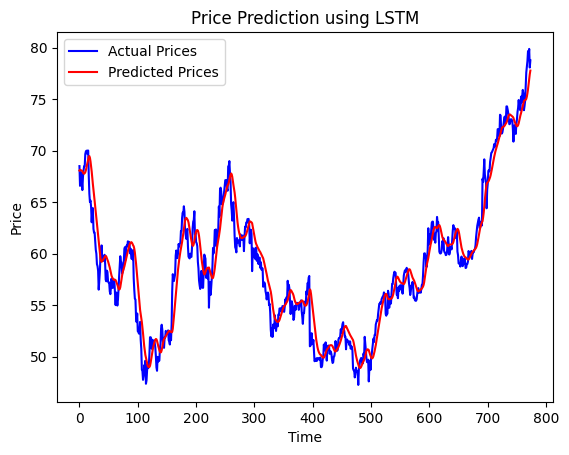

In [137]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_prices))
print(f"Root Mean Squared Error: {rmse}")

# Step 10: Plot the predictions vs. actual values
plt.plot(y_test_rescaled, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [138]:
model.save('lstm_model.h5')  


/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [139]:
last_sequence = scaled_data[-60:]  
last_sequence = last_sequence.reshape(1, 60, 1) 

next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)  

print(f"Next day's predicted price: {next_day_prediction[0][0]}")


1/1 [==============================] - 0s 30ms/step
Next day's predicted price: 78.05494689941406


In [140]:
# Predicting the next week's prices (5 days)
predictions_week = []
current_sequence = scaled_data[-60:]  

for _ in range(5): 
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_week.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  # Shift the sequence for next prediction

print("Predicted prices for next week:", predictions_week)


1/1 [==============================] - 0s 14ms/step
Predicted prices for next week: [78.05495, 78.23336, 78.34338, 78.40647, 78.43774]


In [141]:
print(np.mean(predictions_week))

78.29518


In [142]:
# Predicting the next month's prices (20 days)
predictions_month = []
current_sequence = scaled_data[-60:]  

for _ in range(20):  
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_month.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  # Shift the sequence for next prediction

print("Predicted prices for next month:", predictions_month)


1/1 [==============================] - 0s 15ms/step
Predicted prices for next month: [78.05495, 78.23336, 78.34338, 78.40647, 78.43774, 78.44778, 78.443886, 78.43106, 78.41268, 78.390976, 78.36739, 78.34288, 78.31804, 78.29323, 78.26868, 78.2445, 78.22077, 78.19755, 78.17481, 78.152596]


In [143]:
np.mean((predictions_month))

78.309135

In [144]:
predictions_year = []
current_sequence = scaled_data[-60:]  

for _ in range(252): 
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_year.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  

print("Predicted prices for next year:", predictions_year)


1/1 [==============================] - 0s 13ms/step
Predicted prices for next year: [78.05495, 78.23336, 78.34338, 78.40647, 78.43774, 78.44778, 78.443886, 78.43106, 78.41268, 78.390976, 78.36739, 78.34288, 78.31804, 78.29323, 78.26868, 78.2445, 78.22077, 78.19755, 78.17481, 78.152596, 78.130875, 78.109634, 78.08886, 78.06854, 78.04865, 78.02917, 78.01007, 77.99133, 77.97294, 77.95487, 77.937126, 77.919655, 77.90246, 77.885506, 77.86879, 77.85232, 77.836044, 77.819984, 77.804115, 77.788445, 77.77294, 77.757614, 77.742455, 77.72745, 77.71261, 77.697914, 77.683365, 77.668976, 77.65472, 77.64061, 77.626625, 77.612785, 77.599075, 77.585495, 77.57205, 77.55873, 77.54554, 77.53247, 77.51955, 77.50672, 77.49403, 77.48146, 77.46901, 77.45667, 77.44446, 77.43236, 77.420364, 77.4085, 77.39674, 77.38509, 77.373566, 77.36213, 77.35083, 77.33961, 77.32851, 77.317505, 77.30662, 77.29583, 77.28514, 77.27456, 77.26407, 77.25369, 77.2434, 77.23321, 77.22312, 77.21311, 77.20321, 77.19339, 77.183685, 77.

In [145]:
np.mean((predictions_year))

77.05909

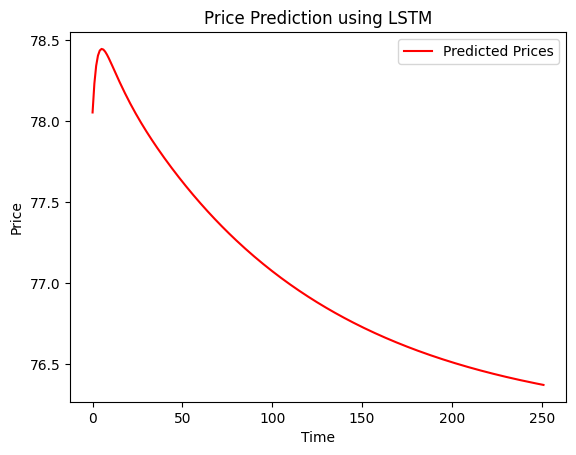

In [146]:
plt.plot(predictions_year, color='red', label='Predicted Prices')
plt.title('Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()